In [6]:
import pandas as pd
import numpy as np

from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense, Reshape
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.embeddings import Embedding

import tensorflow as tf
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt

In [7]:
import pandas as pd 

In [8]:
train_data1=pd.read_csv('../input/english-tohind/english_hindi.csv')

In [9]:
train_data1.to_csv('hey.csv')

In [ ]:
train_data=train_data1[ :100000]

In [ ]:
train_data.shape

In [11]:
train_data.head()

,JANAMDIVAS,^जन्मदिवस$
0,RAKHA,^रक्खा$
1,MILIJULI,^मिलीजुली$
2,JAANCHON,^जांचों$
3,CHAMKATA,^चमकता$
4,KAYIYON,^कईयों$


In [12]:
input_words=train_data['JANAMDIVAS'].tolist()
target_words=train_data['^जन्मदिवस$'].tolist()

In [13]:
print(input_words[0])
print(target_words[0])

RAKHA
^रक्खा$


In [14]:
print(f"Total number of input words {len(input_words)}")
print(f"Total number of target words {len(target_words)}")

Total number of input words 100000
Total number of target words 100000


In [15]:
#removing the duplicates
def build_vocab(input_words, target_words):
  input_vocab = set()
  target_vocab = set()
  for input_word, target_word in zip(input_words, target_words):
      input_vocab.update(set(input_word))
      target_vocab.update(set(target_word))
  return input_vocab, target_vocab

In [16]:
input_vocab, target_vocab = build_vocab(input_words, target_words)

In [17]:
print(input_vocab)
print(target_vocab)

{'B', 'K', 'O', 'A', 'X', 'G', 'L', 'U', 'N', 'W', 'I', 'V', 'T', 'E', 'C', 'D', 'M', 'R', 'J', 'Y', 'H', 'Q', 'Z', 'F', 'P', 'S'}
{'ा', 'ऍ', 'ि', 'ज', 'ड', '$', 'थ', 'ऽ', 'ओ', 'उ', 'ः', 'ै', 'य', 'ॅ', 'े', 'ू', 'म', 'इ', 'झ', 'ऋ', 'ॉ', 'ु', 'च', 'घ', 'छ', 'औ', 'ध', 'श', 'ऐ', 'ो', 'क', 'ह', '़', 'ई', '^', 'ए', 'द', 'ञ', 'ऑ', 'ष', 'स', 'ृ', 'ँ', 'ण', 'न', 'ॊ', 'र', 'ौ', 'ब', 'त', 'ी', 'ङ', 'भ', 'ॠ', 'ख', 'ढ', 'ठ', 'ट', 'ं', 'ळ', 'व', 'प', 'आ', 'ग', 'ॐ', 'ल', 'फ', 'अ', 'ऊ', '्'}


In [18]:
print(f"Total hindi characters {len(input_vocab)}")
print(f"Total english characters {len(target_vocab)}")



Total hindi characters 26
Total english characters 70


In [19]:
input_vocab = sorted(list(input_vocab))
target_vocab = sorted(list(target_vocab))


In [20]:
input_token_index = dict([(char, i) for i, char in enumerate(input_vocab)])
target_token_index = dict([(char, i) for i, char in enumerate(target_vocab)])

In [21]:
print(input_token_index)
print(target_token_index)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}
{'$': 0, '^': 1, 'ँ': 2, 'ं': 3, 'ः': 4, 'अ': 5, 'आ': 6, 'इ': 7, 'ई': 8, 'उ': 9, 'ऊ': 10, 'ऋ': 11, 'ऍ': 12, 'ए': 13, 'ऐ': 14, 'ऑ': 15, 'ओ': 16, 'औ': 17, 'क': 18, 'ख': 19, 'ग': 20, 'घ': 21, 'ङ': 22, 'च': 23, 'छ': 24, 'ज': 25, 'झ': 26, 'ञ': 27, 'ट': 28, 'ठ': 29, 'ड': 30, 'ढ': 31, 'ण': 32, 'त': 33, 'थ': 34, 'द': 35, 'ध': 36, 'न': 37, 'प': 38, 'फ': 39, 'ब': 40, 'भ': 41, 'म': 42, 'य': 43, 'र': 44, 'ल': 45, 'ळ': 46, 'व': 47, 'श': 48, 'ष': 49, 'स': 50, 'ह': 51, '़': 52, 'ऽ': 53, 'ा': 54, 'ि': 55, 'ी': 56, 'ु': 57, 'ू': 58, 'ृ': 59, 'ॅ': 60, 'े': 61, 'ै': 62, 'ॉ': 63, 'ॊ': 64, 'ो': 65, 'ौ': 66, '्': 67, 'ॐ': 68, 'ॠ': 69}


In [22]:

num_encoder_tokens = len(input_vocab)
num_decoder_tokens = len(target_vocab)

In [23]:
max_encoder_seq_length = max([len(txt) for txt in input_words])
max_decoder_seq_length = max([len(txt) for txt in target_words])

In [24]:
print('Number of samples:', len(input_words))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 100000
Number of unique input tokens: 26
Number of unique output tokens: 70
Max sequence length for inputs: 25
Max sequence length for outputs: 30


In [25]:
encoder_input_data = np.zeros((len(input_words), max_encoder_seq_length, num_encoder_tokens), dtype='float32')
decoder_input_data = np.zeros((len(input_words), max_decoder_seq_length, num_decoder_tokens), dtype='float32')
decoder_target_data = np.zeros( (len(input_words), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

In [26]:
print(f"encoder input shape {encoder_input_data.shape}")
print(f"decoder input shape {decoder_input_data.shape}")

encoder input shape (100000, 25, 26)
decoder input shape (100000, 30, 70)


In [27]:
class Scaled_Dot_product_Attention(tf.keras.layers.Layer):
    def __init__(self,units):
        super().__init__(Scaled_dot_product_Attention)
        
        self.units=units
        self.Wq=tf.keras.layers.Dense(self.units)
        self.Wk=tf.keras.layers.Dense(self.units)
        self.Wv=tf.keras.layers.Dense(256)
        
    def forward(self,q,v,n,k):
        self.q=q
        self.v=v
        self.n=n
        self.k=n
        self,n=n
        
        q_t=tf.expand_dims(self.q,1)
        
        score=(self.Wq(self.q)*self.Wk(self.k))/math.sqrt(n)
        
        attention_wts=tf.nn.softmax(score,axis=1)
        context_vector=(attention_wts*self.v)
        
        context_vector=tf.reduce_sum(context_vector,axis=1)
        
        return context_vector,attention_wts
        
        

In [28]:
for i, (input_text, target_text) in enumerate(zip(input_words, target_words)):
  for t, char in enumerate(input_text):
    encoder_input_data[i, t, input_token_index[char]] = 1.0
  # for the rest of sentence, mark it as space
  #encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0

  for t, char in enumerate(target_text):
    # decoder_target_data is ahead of decoder_input_data by one timestep
    decoder_input_data[i, t, target_token_index[char]] = 1.0
    if t > 0:
      # decoder_target_data will be ahead by one timestep
      # and will not include the start character.
      decoder_target_data[i, t-1, target_token_index[char]] = 1.0
      # for the rest of sentence, mark it as space
      #decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0

In [29]:
import math
class Scaled_Dot_Product_Self_Attention(tf.keras.layers.Layer):
    #A class for Self Attention- Q,K,V dimensions
    def __init__(self,units):
        super(Scaled_Dot_Product_Self_Attention,self).__init__()
        self.units=units
        self.Wq=tf.keras.layers.Dense(self.units)
        self.Wk=tf.keras.layers.Dense(self.units)
        self.Wv=tf.keras.layers.Dense(256)
        
    def call(self,q,k,v,n):
        self.q=q
        self.v=v
        self.n=n
        self.k=k
#         print(self.q.shape)
        q_t=tf.expand_dims(self.q,1)
#         self.q=tf.transpose(self.q)
        score=(self.Wq(self.q)*self.Wk(self.k))/math.sqrt(n)
        attention_wts=tf.nn.softmax(score,axis=1)
#         print(attention_wts.shape)
        context_vector=(attention_wts*self.v)
        context_vector=tf.reduce_sum(context_vector,axis=1)
#         print(context_vector.shape)
        return context_vector,attention_wts

In [30]:
latent_dim = 256  # Latent dimensionality of the encoding space.
EMBEDDING_SIZE = 100

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
print(encoder_inputs.shape)

# Define embedding layer
encoder_embedding = Embedding(num_encoder_tokens, EMBEDDING_SIZE, input_length=max_encoder_seq_length)
encoder_inputs_em = encoder_embedding(encoder_inputs)
print(encoder_inputs_em.shape)

# since embedding layer will add one more dim, we need to flatten last 2 dims
encoder_reshape = Reshape((-1, encoder_inputs_em.shape[2] * encoder_inputs_em.shape[3]))
encoder_inputs_re = encoder_reshape(encoder_inputs_em)
print(encoder_inputs_re.shape)

# Note that LSTM takes only 3 dims, (samples, timesteps, features)
encoder = LSTM(latent_dim, return_state=True)

encoder_outputs, state_h, state_c = encoder(encoder_inputs_re)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

(None, None, 26)
(None, None, 26, 100)
(None, None, 2600)


2022-11-23 18:38:40.473449: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [31]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
print(decoder_inputs.shape)

# Define embeddling layer
decoder_embedding = Embedding(num_decoder_tokens, latent_dim)
decoder_inputs_em = decoder_embedding(decoder_inputs)
print(decoder_inputs_em.shape)


(None, None, 70)
(None, None, 70, 256)


In [32]:
scaled_dot_product_attention=Scaled_Dot_Product_Self_Attention(256)
decoder_embed_attention_h,decoder_embed_wghts_h=scaled_dot_product_attention(state_h,state_h,encoder_outputs,256)
decoder_embed_attention_c,decoder_embed_wghts_c=scaled_dot_product_attention(state_c,state_c,encoder_outputs,256)

In [33]:
# since embedding layer will add one more dim, we need to flatten last 2 dims
decoder_reshape = Reshape((-1, decoder_inputs_em.shape[2] * decoder_inputs_em.shape[3]))
decoder_inputs_re = decoder_reshape(decoder_inputs_em)
print(decoder_inputs_re.shape)
decoder = LSTM(latent_dim, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder(decoder_inputs_re, initial_state=[decoder_embed_wghts_h,decoder_embed_wghts_c])
print(decoder_outputs.shape)

decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
print(decoder_outputs.shape)

(None, None, 17920)
(None, None, 256)
(None, None, 70)


### Attention

In [34]:

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 26)]   0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 26, 100 2600        input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 70)]   0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, None, 2600)   0           embedding[0][0]                  
______________________________________________________________________________________________

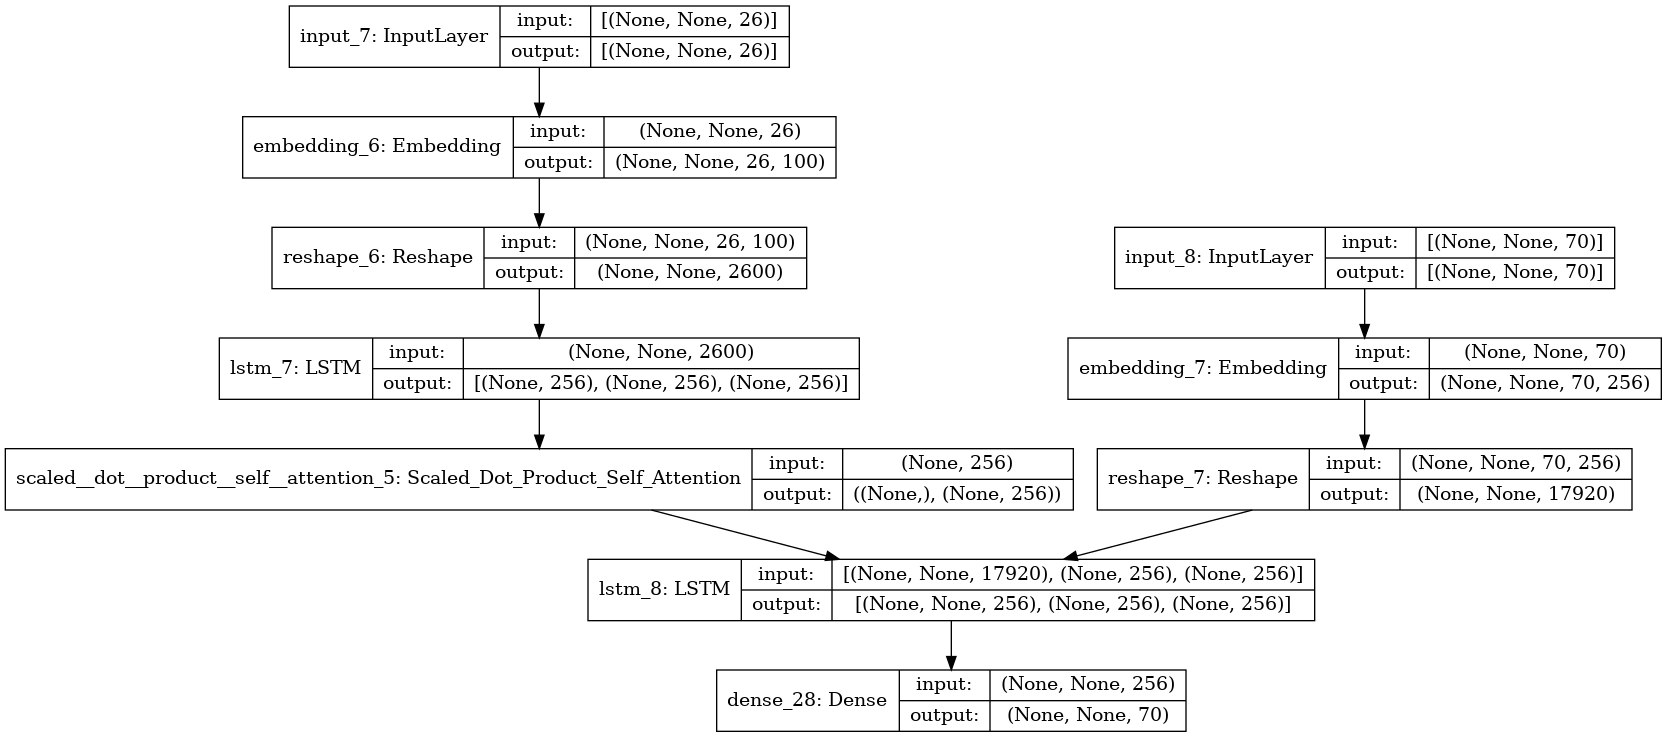

In [57]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
# Training
batch_size = 64  # Batch size for training.
epochs = 500  # Number of epochs to train for.
initial_learning_rate = 0.001

# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy
model_save_filename = "model.h5_final"
with tf.device('/device:GPU:0'):
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=initial_learning_rate), 
        loss='categorical_crossentropy', 
        metrics=['accuracy'])

    earlystopping_cb = EarlyStopping(
        monitor="val_accuracy",
        mode="max",
        verbose=1,
        patience=20, 
        restore_best_weights=True)

    mdlcheckpoint_cb = ModelCheckpoint(
        model_save_filename, 
        monitor="val_accuracy", 
        mode="max",
        verbose=1,
        save_best_only=True
    )

    decay = initial_learning_rate / epochs
    def lr_time_based_decay(epoch, lr):
        return lr * 1 / (1 + decay * epoch)
    lrscheduler_cb = tf.keras.callbacks.LearningRateScheduler(lr_time_based_decay)

    history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
              batch_size=batch_size, epochs=epochs,  validation_split=0.2, 
              callbacks=[earlystopping_cb, mdlcheckpoint_cb, lrscheduler_cb])

In [59]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


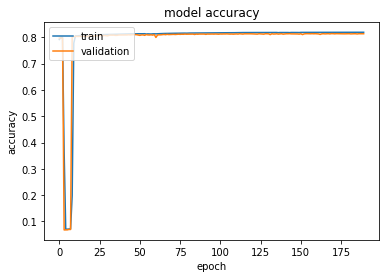

In [60]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

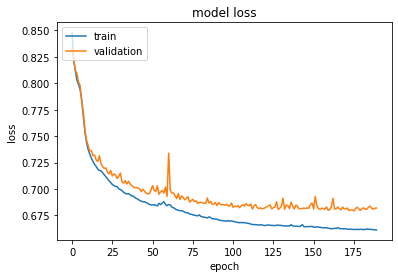

In [62]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Restore the model and construct the encoder and decoder.
model = load_model(model_save_filename)
# model = load_model("model_v1.h5")

In [ ]:
model

In [ ]:
# Predictions
encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[6].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]

encoder_model = Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_inputs_em = decoder_embedding(decoder_inputs)

# since embedding layer will add one more dim, we need to flatten last 2 dims
decoder_reshape = Reshape((-1, decoder_inputs_em.shape[2] * decoder_inputs_em.shape[3]))
decoder_inputs_re = decoder_reshape(decoder_inputs_em)
print(decoder_inputs_re.shape)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_lstm = model.layers[7] # lstm_2
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs_re, initial_state=decoder_states_inputs
)

decoder_states = [state_h_dec, state_c_dec]

decoder_dense = model.layers[-1]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

In [48]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

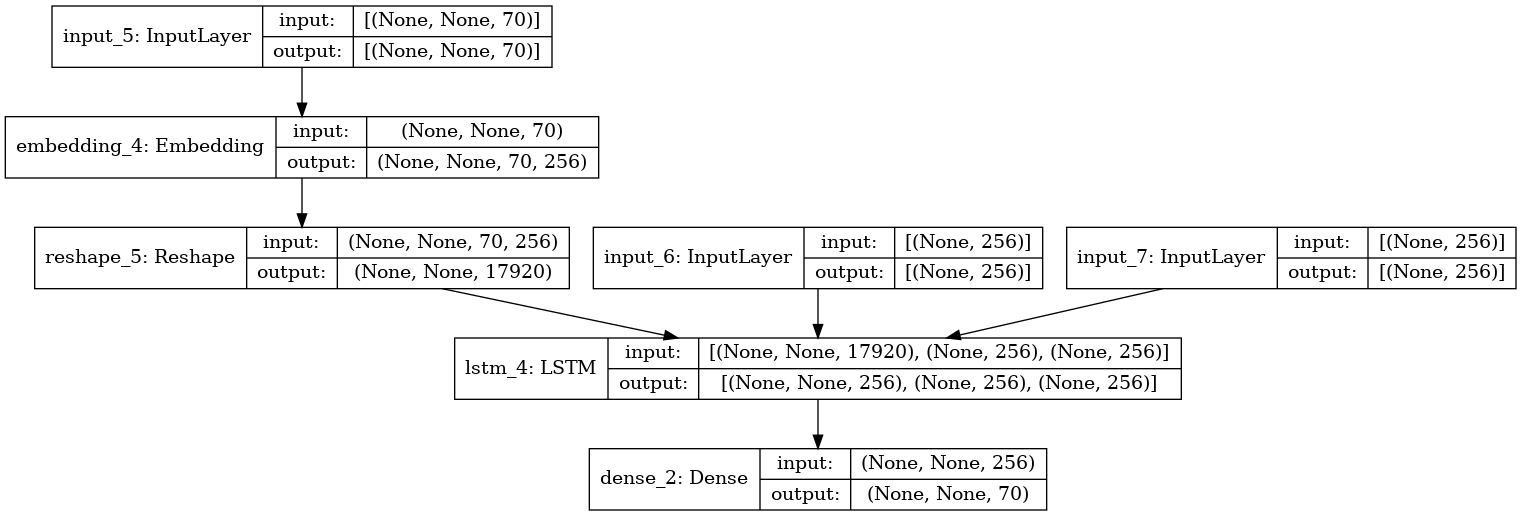

In [49]:
tf.keras.utils.plot_model(decoder_model, to_file='model_plot_dec.png', show_shapes=True, show_layer_names=True)

In [50]:
def predict_target(input_string):
  # convert for encoding 
  input_data = np.zeros((1, max_encoder_seq_length, num_encoder_tokens), dtype='float32')
  for t, char in enumerate(input_string):
    input_data[0, t, input_token_index[char]] = 1.

  # Encode the input as state vectors.
  states_value = encoder_model(input_data)

   # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1, num_decoder_tokens), dtype='float32')
  # Populate the first character of target sequence with the start character.
  target_seq[0, 0, target_token_index['^']] = 1.0

  stop_condition = False
  decoded_sentence = ""

  while True:
    output_tokens, d_h, d_c = decoder_model.predict([target_seq] + states_value)
    # Sample a token
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = reverse_target_char_index[sampled_token_index]

    # Exit condition: either hit max length
    # or find stop character.
    if sampled_char == "$" or len(decoded_sentence) > max_decoder_seq_length:
      break
      
    decoded_sentence += sampled_char

    # Update the target sequence (of length 1).
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, sampled_token_index] = 1.0

    # Update states
    states_value = [d_h, d_c]
  return decoded_sentence

In [51]:
input_token_index = dict([(char, i) for i, char in enumerate(input_vocab)])
target_token_index = dict([(char, i) for i, char in enumerate(target_vocab)])

In [79]:
import re
def preprocess(inp_str):
    spaces=[]
    for i in range(len(inp_str)):
        if inp_str[i]==' ':
            spaces.append(i)
            
    sentence = re.sub(r"\s+", "", inp_str, flags=re.UNICODE)
    return sentence.upper(),spaces

In [81]:
preprocess("sahitya arya hey")

('SAHITYAARYAHEY', [7, 12])

In [97]:

test_input,spaces = preprocess('Sahitya')
predicted_string = predict_target(test_input)
predicted_string

'साहित्य'

In [92]:
def insert_str(string, str_to_insert, index):
    return string[:index] + str_to_insert + string[index:]

In [93]:
insert_str(predicted_string,' ',7)

'साहित्य ार्य'